In [1]:
import os
parent_path = os.path.dirname(os.getcwd())
os.chdir(parent_path)

In [2]:
from utils.dataloader import GraphTextDataset, GraphDataset, TextDataset
from torch_geometric.data import DataLoader
# from models.Model import BaseModel
from models.model2 import GAT_MLP
# from models.model3_transfert_learning import GAT_MLP_TL
import numpy as np
from transformers import AutoTokenizer
import torch
from torch import optim
import time
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.variables import ROOT_DIR

torch.cuda.empty_cache()

In [3]:
train = pd.read_csv(ROOT_DIR + '/data/train.tsv', sep='\t', header=None)
sample_train = train.sample(6000, random_state=42)
sample_train.to_csv(ROOT_DIR + '/data/sample_train.tsv', sep='\t', header=False, index=False)

In [4]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
val_dataset = GraphTextDataset(root='./data/', gt=gt, split='val', tokenizer=tokenizer)
train_dataset = GraphTextDataset(root='./data/', gt=gt, split='sample_train', tokenizer=tokenizer)

In [5]:
# loading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(ROOT_DIR + '/logs/model_20241127_171613.pt')
model = GAT_MLP(model_name=model_name, num_node_features=300, nout=768, nhid=300, graph_hidden_channels=300) 
model.load_state_dict(checkpoint)
model.to(device)

/tmp/ipykernel_973650/1274117589.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ROOT_DIR + '/logs/model_20241127_171613.pt')
2024-11-29 19:08:17

GAT_MLP(
  (graph_encoder): GraphEncoder(
    (relu): ReLU()
    (ln): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (conv1): GATConv(300, 300, heads=1)
    (conv2): GATConv(300, 300, heads=1)
    (conv3): GATConv(300, 300, heads=1)
    (mol_hidden1): Linear(in_features=300, out_features=300, bias=True)
    (mol_hidden2): Linear(in_features=300, out_features=768, bias=True)
  )
  (text_encoder): TextEncoder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31090, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_featur

In [6]:
data_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

model.eval()
count = 0 

graphs_embedding = []
texts_embedding = []
for batch in data_loader:
    count +=1
    input_ids = batch.input_ids
    batch.pop('input_ids')
    attention_mask = batch.attention_mask
    batch.pop('attention_mask')
    graph_batch = batch
    
    x_graph, x_text = model(graph_batch.to(device), 
                            input_ids.to(device), 
                            attention_mask.to(device))
    
    x_graph = x_graph.detach().cpu()
    x_text = x_text.detach().cpu()

    graphs_embedding.append(x_graph)
    texts_embedding.append(x_text)

/Data/victor.zhuang/Code/MIT/env/lib64/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Data/victor.zhuang/Code/Molecule Retrieval/utils/dataloader.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wh

In [7]:
graphs_embedding = torch.cat(graphs_embedding, dim=0)
texts_embedding = torch.cat(texts_embedding, dim=0)

In [8]:
texts = pd.DataFrame(val_dataset.description)
graph_df = pd.DataFrame(graphs_embedding.numpy(), columns=[f'graph_emb_{i}' for i in range(graphs_embedding.shape[1])], index=texts.index)
text_df = pd.DataFrame(texts_embedding.numpy(), columns=[f'text_emb_{i}' for i in range(texts_embedding.shape[1])], index=texts.index)

In [10]:
graphs_embedding_normalized = (graph_df - graph_df.mean()) / graph_df.std()
texts_embedding_normalized = (text_df - text_df.mean()) / text_df.std()

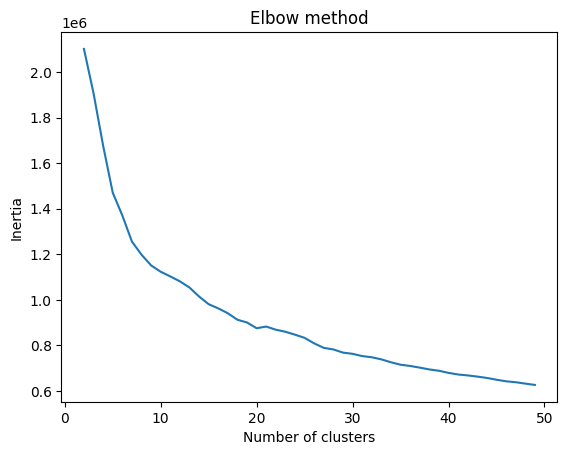

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pca = PCA(n_components=30, random_state=42)
pca_graphs = pca.fit_transform(graphs_embedding_normalized)

# elbow method to find the optimal number of clusters
inertia = []
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_graphs)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 50), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(pca_graphs)
graph_df['cluster'] = kmeans.labels_

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = graph_df.drop('cluster', axis=1)
y = graph_df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [14]:
print(f'Accuracy: {accuracy}')

Accuracy: 0.9561270801815431


In [15]:
X = text_df
y = graph_df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8502269288956127


In [16]:
pca = PCA(n_components=170, random_state=42)
pca_text = pca.fit_transform(texts_embedding_normalized)

kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(pca_text)
text_df['cluster'] = kmeans.labels_

In [17]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(np.concatenate((pca_graphs, pca_text), axis=1))
clusters = kmeans.labels_

In [18]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print('Similarity between graph and text embeddings')
print(f'ARI: {adjusted_rand_score(graph_df["cluster"], text_df["cluster"])}')
print(f'NMI: {normalized_mutual_info_score(graph_df["cluster"], text_df["cluster"])}')
print('')

print('Similarity between graph and graph+text embeddings')
print(f'ARI: {adjusted_rand_score(graph_df["cluster"], clusters)}')
print(f'NMI: {normalized_mutual_info_score(graph_df["cluster"], clusters)}')
print('')

print('Similarity between text and graph+text embeddings')
print(f'ARI: {adjusted_rand_score(clusters, text_df["cluster"])}')
print(f'NMI: {normalized_mutual_info_score(clusters, text_df["cluster"])}')

Similarity between graph and text embeddings
ARI: 0.42784732694571476
NMI: 0.47768014448490737

Similarity between graph and graph+text embeddings
ARI: 0.717217538478941
NMI: 0.7728277273171267

Similarity between text and graph+text embeddings
ARI: 0.4870147598331233
NMI: 0.5544920239320449


In [19]:
X = text_df
y = text_df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


In [20]:
X = graph_df
y = text_df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8078668683812406


In [21]:
texts.loc[text_df['cluster']==7]

,1
21524386,R. ruber mycolic acid is a forty-six membered ...
25010750,N-hydroxytrihomomethionine is an N-hydroxy-alp...
16722148,Linkable Ro 320-1195 analogue is a racemic ana...
521348,3-mercaptohexanol is an alkanethiol that is he...
10700053,"(2S)-1-O-(7Z,10Z,13Z)-hexadecatrienoyl-2-O-(7Z..."
...,...
136227920,5'-AICm(1)IUp-3' is a tRNA oligonucleotide com...
8640,1-naphthylamine is a naphthylamine that is nap...
20640234,2-methyl-L-glutamine is a non-proteinogenic L-...
11373102,Isoiguesterin is a pentacyclic triterpenoid th...


In [32]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

processed_texts = []
for text in texts.loc[clusters==8, 1]:
    processed_texts.append(' '.join([word for word in text.split() if word not in stop_words]))

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(processed_texts)
tfidf_matrix = tfidf_matrix.toarray()

# get the most important words
feature_names = np.array(tfidf.get_feature_names_out())
sorted_tfidf = np.argsort(tfidf_matrix.sum(axis=0))
important_words = feature_names[sorted_tfidf[-20:]]
print(important_words)

['fatty' 'substituted' 'groups' 'methyl' 'phosphate' 'compound' 'base'
 'position' 'derives' 'amino' 'member' 'conjugate' 'hydroxy' 'role'
 'metabolite' 'group' 'alpha' 'beta' 'acid' 'it']
